# F1 Fastest Race Lap Predictions
__Author:__ Sofia Cipollone, 2024/2025

## Domain Context
> Formula One (F1) is the highest class of worldwide racing for open-wheel single-seater racing cars sanctioned by the Fédération Internationale de l'Automobile (FIA).
>
> A Formula One season consists of a series of races, known as Grands Prix. The FIA sets a series of sporting and technical regulations, among others, that have to be followed by the participants of said Grand Prix.
>
> The current qualifying system was adopted in the 2006 season. Known as "knock-out" qualifying, it is split into three periods, known as Q1, Q2, and Q3. In each period, drivers run qualifying laps to attempt to advance to the next period, with the slowest drivers being "knocked out" of qualification (but not necessarily the race). After each period, all times are reset, and only a driver's fastest lap in that period counts. Each qualifying period the slowest five drivers are eliminated.
>
> A Formula One constructor is the entity credited for designing the chassis and the engine. Therefore, the FIA Formula One World Championship is not disputed between equal machinery.

*Adapted from [Wikipedia](https://en.wikipedia.org/wiki/Formula_One).*

## The Objective
This Notebook aims to predict the fastest race lap by using datasets containing data related to qualifying sessions, races (Grand Prix), race results, drivers and constructors.
We proceed by downloading the necessary datasets using `kagglehub` API.

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

### Kagglehub Installation
Install `kagglehub` using `pip` or `conda` by uncommenting the necessary code cells.

In [52]:
# %pip install kagglehub

In [53]:
# %conda install conda-forge::kagglehub

In [54]:
import kagglehub

quali_path = kagglehub.dataset_download(
    "rohanrao/formula-1-world-championship-1950-2020",
    path='qualifying.csv'
)
races_path = kagglehub.dataset_download(
    "rohanrao/formula-1-world-championship-1950-2020",
    path='races.csv'
)
results_path = kagglehub.dataset_download(
    "rohanrao/formula-1-world-championship-1950-2020",
    path='results.csv'
)
drivers_path = kagglehub.dataset_download(
    "rohanrao/formula-1-world-championship-1950-2020",
    path='drivers.csv'
)
constructors_path = kagglehub.dataset_download(
    "rohanrao/formula-1-world-championship-1950-2020",
    path='constructors.csv'
)

print("Path to dataset files:", races_path, quali_path, results_path, drivers_path, constructors_path, sep='\n')

Path to dataset files:
/home/sofi/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/races.csv
/home/sofi/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/qualifying.csv
/home/sofi/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/results.csv
/home/sofi/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/drivers.csv
/home/sofi/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24/constructors.csv


## Dataframe Creation
The datasets contain missing values referred as `\N`. We will parse them so they contain the `NaN` value instead. This will make handling missing values smoother with Python.

In [55]:
quali = pd.read_csv(
    quali_path,
    index_col='qualifyId',
    na_values='\\N'
)
quali.head(5)

,raceId,driverId,constructorId,number,position,q1,q2,q3
qualifyId,,,,,,,,
1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
5,18,2,2,3,5,1:25.960,1:25.518,1:27.236


In [56]:
races = pd.read_csv(
    races_path,
    index_col='raceId',
    parse_dates=['date'],
    na_values='\\N'
)
races.head(5)

,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
raceId,,,,,,,,,,,,,,,,,
1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
race_results = pd.read_csv(
    results_path,
    index_col='resultId',
    na_values='\\N'
)
race_results.head(5)

,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
resultId,,,,,,,,,,,,,,,,,
1,18,1,1,22.0,1,1.0,1,1,10.0,58,1:34:50.616,5690616.0,39.0,2.0,1:27.452,218.300,1
2,18,2,2,3.0,5,2.0,2,2,8.0,58,+5.478,5696094.0,41.0,3.0,1:27.739,217.586,1
3,18,3,3,7.0,7,3.0,3,3,6.0,58,+8.163,5698779.0,41.0,5.0,1:28.090,216.719,1
4,18,4,4,5.0,11,4.0,4,4,5.0,58,+17.181,5707797.0,58.0,7.0,1:28.603,215.464,1
5,18,5,1,23.0,3,5.0,5,5,4.0,58,+18.014,5708630.0,43.0,1.0,1:27.418,218.385,1


In [58]:
drivers = pd.read_csv(
    drivers_path,
    index_col='driverId',
    na_values='\\N'
)
drivers.head(5)

,driverRef,number,code,forename,surname,dob,nationality,url
driverId,,,,,,,,
1,hamilton,44.0,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
2,heidfeld,NaN,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
3,rosberg,6.0,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
4,alonso,14.0,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
5,kovalainen,NaN,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [59]:
constructors = pd.read_csv(
    constructors_path,
    index_col='constructorId'
)
constructors

,constructorRef,name,nationality,url
constructorId,,,,
1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso
...,...,...,...,...
210,haas,Haas F1 Team,American,http://en.wikipedia.org/wiki/Haas_F1_Team
211,racing_point,Racing Point,British,http://en.wikipedia.org/wiki/Racing_Point_F1_Team
213,alphatauri,AlphaTauri,Italian,http://en.wikipedia.org/wiki/Scuderia_AlphaTauri


## Ground effect cars era (2022–2025)
Since the FIA is in charge of setting the technical regulations, we have decided to train the model on data from the most recent "ground effect cars" era.

This dataset does not include data for the current 2025 season, since it is still being disputed.

*Note: Ground effect, in automotive aerodynamics, aims to create downforce (a downwards lift force that increases the vertical force on the tires, thus creating more grip).*

In [60]:
races = races.loc[(races['year'] >= 2022) & (races['year'] <= 2024)]
races = races[['year', 'name']]
races.head(5)

,year,name
raceId,,
1074,2022,Bahrain Grand Prix
1075,2022,Saudi Arabian Grand Prix
1076,2022,Australian Grand Prix
1077,2022,Emilia Romagna Grand Prix
1078,2022,Miami Grand Prix


Considering the presence of multiple datasets, it is needed to merge them into a single dataframe. The merge will also allow only the data from 2022 to be kept.

Here is the list of columns that will be kept per dataframe:
- Qualifying
    - raceId
    - driverId
    - q1
    - q2
    - q3
- Race results
    - raceId
    - driverId
    - constructorId
    - fastestLapTime
- Drivers
    - surname
- Constructors
    - name

The ID columns are kept to be used in the merge. Once the merge is complete, they will be dropped from the dataframe.

In [61]:
data = races.merge(quali[['raceId', 'driverId', 'q1', 'q2', 'q3']], on='raceId')
data = data.merge(race_results[['raceId', 'driverId', 'constructorId', 'fastestLapTime']], on=['raceId', 'driverId'])
data = data.merge(drivers['surname'], on='driverId')
data = data.merge(constructors['name'], suffixes=('_race', '_constructor'), on='constructorId')

All missing values in the column `fastestLapTime` have to be removed. This is the value that we want to predict and not having any value means that the driver could not participate in the race, or had retired before completing a single lap.

Rows that are missing all values for Q1, Q2 and Q3 will also be dropped. This means that the driver did not participate in the first qualifying (therefore in any qualifying session).

In [62]:
data = data.dropna(subset='fastestLapTime')
data = data.dropna(subset=['q1', 'q2', 'q3'], how='all')
data = data.drop(['driverId', 'constructorId', 'raceId'], axis=1)

Formula One's lap time format is `M:SS.mmm` (e.g. `1:21.456`). To be able to manipulate such values, we need to convert them to seconds first:

In [63]:
def lap_time_to_seconds(time):
    if pd.isna(time):
        return np.nan
    minutes, seconds = time.split(':')
    return int(minutes) * 60 + float(seconds)

A new column `bestQualiTime` will be added. It represents the best qualifying lap time for each driver. This is needed since in our current dataframe there will be plenty of missing values for Q2 and Q3, considering that drivers will be eliminated during said sessions.

We will train the model on this new column, rather than the single "q_" columns. This way we have avoided handling `NaN` values.

In [64]:
for col in ['q1', 'q2', 'q3', 'fastestLapTime']:
    data[col] = data[col].apply(lap_time_to_seconds)

data['bestQualiTime'] = data[['q1', 'q2', 'q3']].min(axis=1, skipna=True)

To predict the fastest race lap, we will use the following independent variables:
- `bestQualiTime`: the driver's best lap time, scored during the span of the whole qualifying sessions
- `surname`: the driver's surname, since each driver has different driving styles (aggressive, conservative, etc.), this will help us differenciate them
- `name_constructor`: the constructor's name (not every team can usually compete for the podium)

Since we are facing both numeric and categorical variables, we will divide them into two arrays:

In [65]:
numeric_vars = ['bestQualiTime']
categorical_vars = ['surname', 'name_constructor']

In [66]:
data['surname'].unique()

array(['Leclerc', 'Verstappen', 'Sainz', 'Pérez', 'Hamilton', 'Bottas',
       'Magnussen', 'Alonso', 'Russell', 'Gasly', 'Ocon', 'Schumacher',
       'Norris', 'Albon', 'Zhou', 'Tsunoda', 'Hülkenberg', 'Ricciardo',
       'Stroll', 'Latifi', 'Vettel', 'de Vries', 'Sargeant', 'Piastri',
       'Lawson', 'Bearman', 'Colapinto', 'Doohan'], dtype=object)

In [67]:
data['name_constructor'].unique()

array(['Ferrari', 'Red Bull', 'Mercedes', 'Alfa Romeo', 'Haas F1 Team',
       'Alpine F1 Team', 'AlphaTauri', 'McLaren', 'Williams',
       'Aston Martin', 'RB F1 Team', 'Sauber'], dtype=object)

# Dataset Analysis

In [68]:
data.describe()

,year,q1,q2,q3,fastestLapTime,bestQualiTime
count,1287.000000,1287.000000,966.000000,634.000000,1287.000000,1287.000000
mean,2023.015540,86.418028,85.546690,85.051981,88.952528,85.559869
std,0.820466,11.686467,11.406373,11.117748,11.243145,11.451450
min,2022.000000,65.116000,64.469000,64.314000,67.012000,64.314000
25%,2022.000000,78.242000,77.589000,76.758000,80.474000,77.379500
50%,2023.000000,86.038000,85.188000,84.895500,88.195000,84.769000
75%,2024.000000,92.488000,91.470000,90.984000,96.920000,91.945000
max,2024.000000,128.510000,126.688000,123.095000,125.585000,128.510000


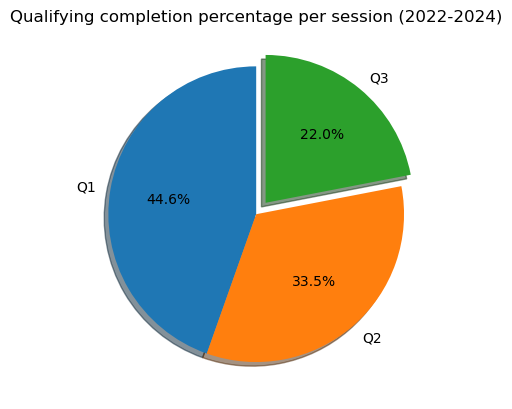

In [69]:
plt.title('Qualifying completion percentage per session (2022-2024)')
plt.pie(
    data[['q1', 'q2', 'q3']].count(),
    labels=['Q1', 'Q2', 'Q3'],
    autopct='%1.1f%%',
    explode=(0, 0, 0.1),
    shadow=True,
    startangle=90
);

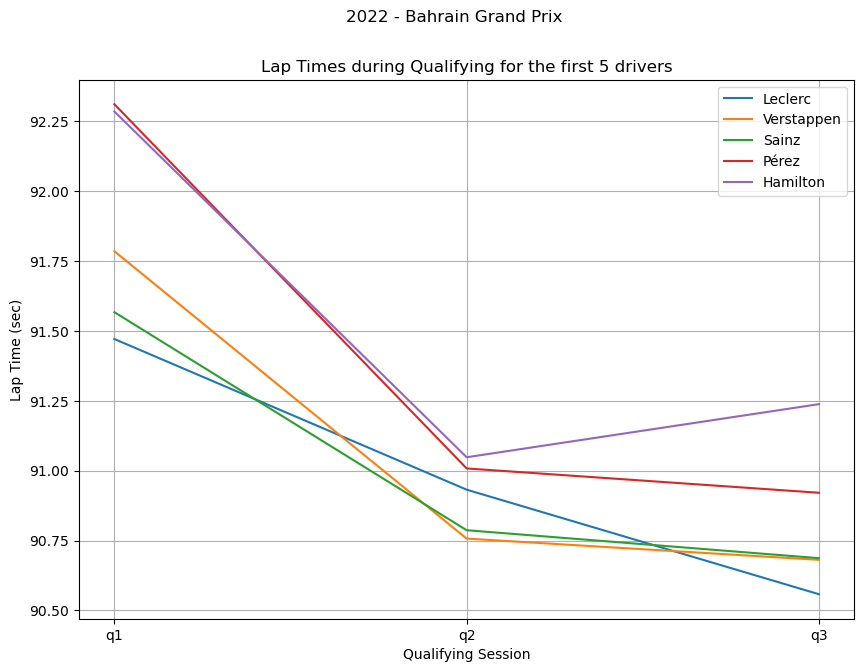

In [70]:
plt.figure(figsize=(10, 7))
plt.suptitle('2022 - Bahrain Grand Prix')
plt.title('Lap Times during Qualifying for the first 5 drivers')
plt.plot(data[['q1', 'q2', 'q3']].head(5).T)
plt.xlabel('Qualifying Session')
plt.ylabel('Lap Time (sec)')
plt.legend(data['surname'])
plt.grid(True);

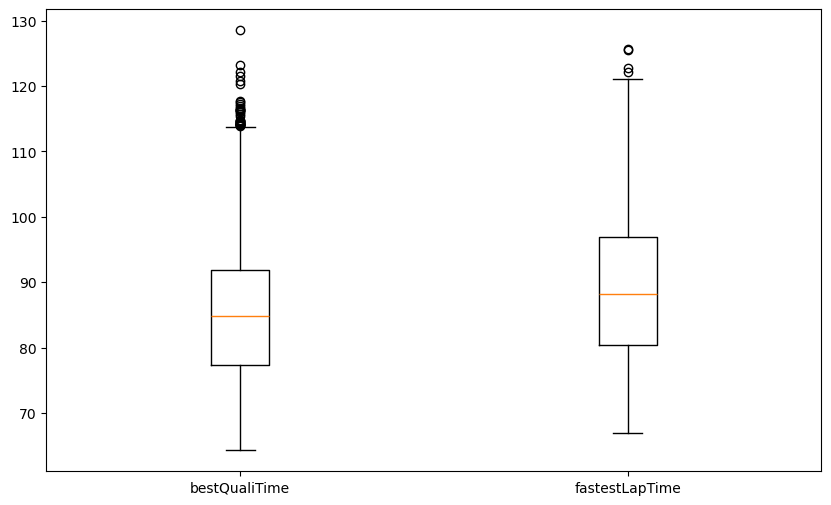

In [233]:
plt.figure(figsize=(10, 6))
plt.boxplot(data[['bestQualiTime', 'fastestLapTime']], tick_labels=['bestQualiTime', 'fastestLapTime']);

# Model Training and Validation

In [234]:
X = data[['bestQualiTime', 'surname', 'name_constructor']]
y = data['fastestLapTime']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [235]:
# TODO: print performance, and model analysis

In [236]:
model = Pipeline([
    ('preproc', ColumnTransformer([
        ('numeric', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(include_bias=False))
        ]), numeric_vars),
        ('categorical', OneHotEncoder(), categorical_vars)
    ])),
    ('regr', Ridge())
])

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8343455672639493

In [237]:
model = Pipeline([
    ('preproc', ColumnTransformer([
        ('numeric', StandardScaler(), numeric_vars),
        ('categorical', OneHotEncoder(), categorical_vars)
    ])),
    ('regr', DecisionTreeRegressor(max_depth=4))
])

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8681740234266662

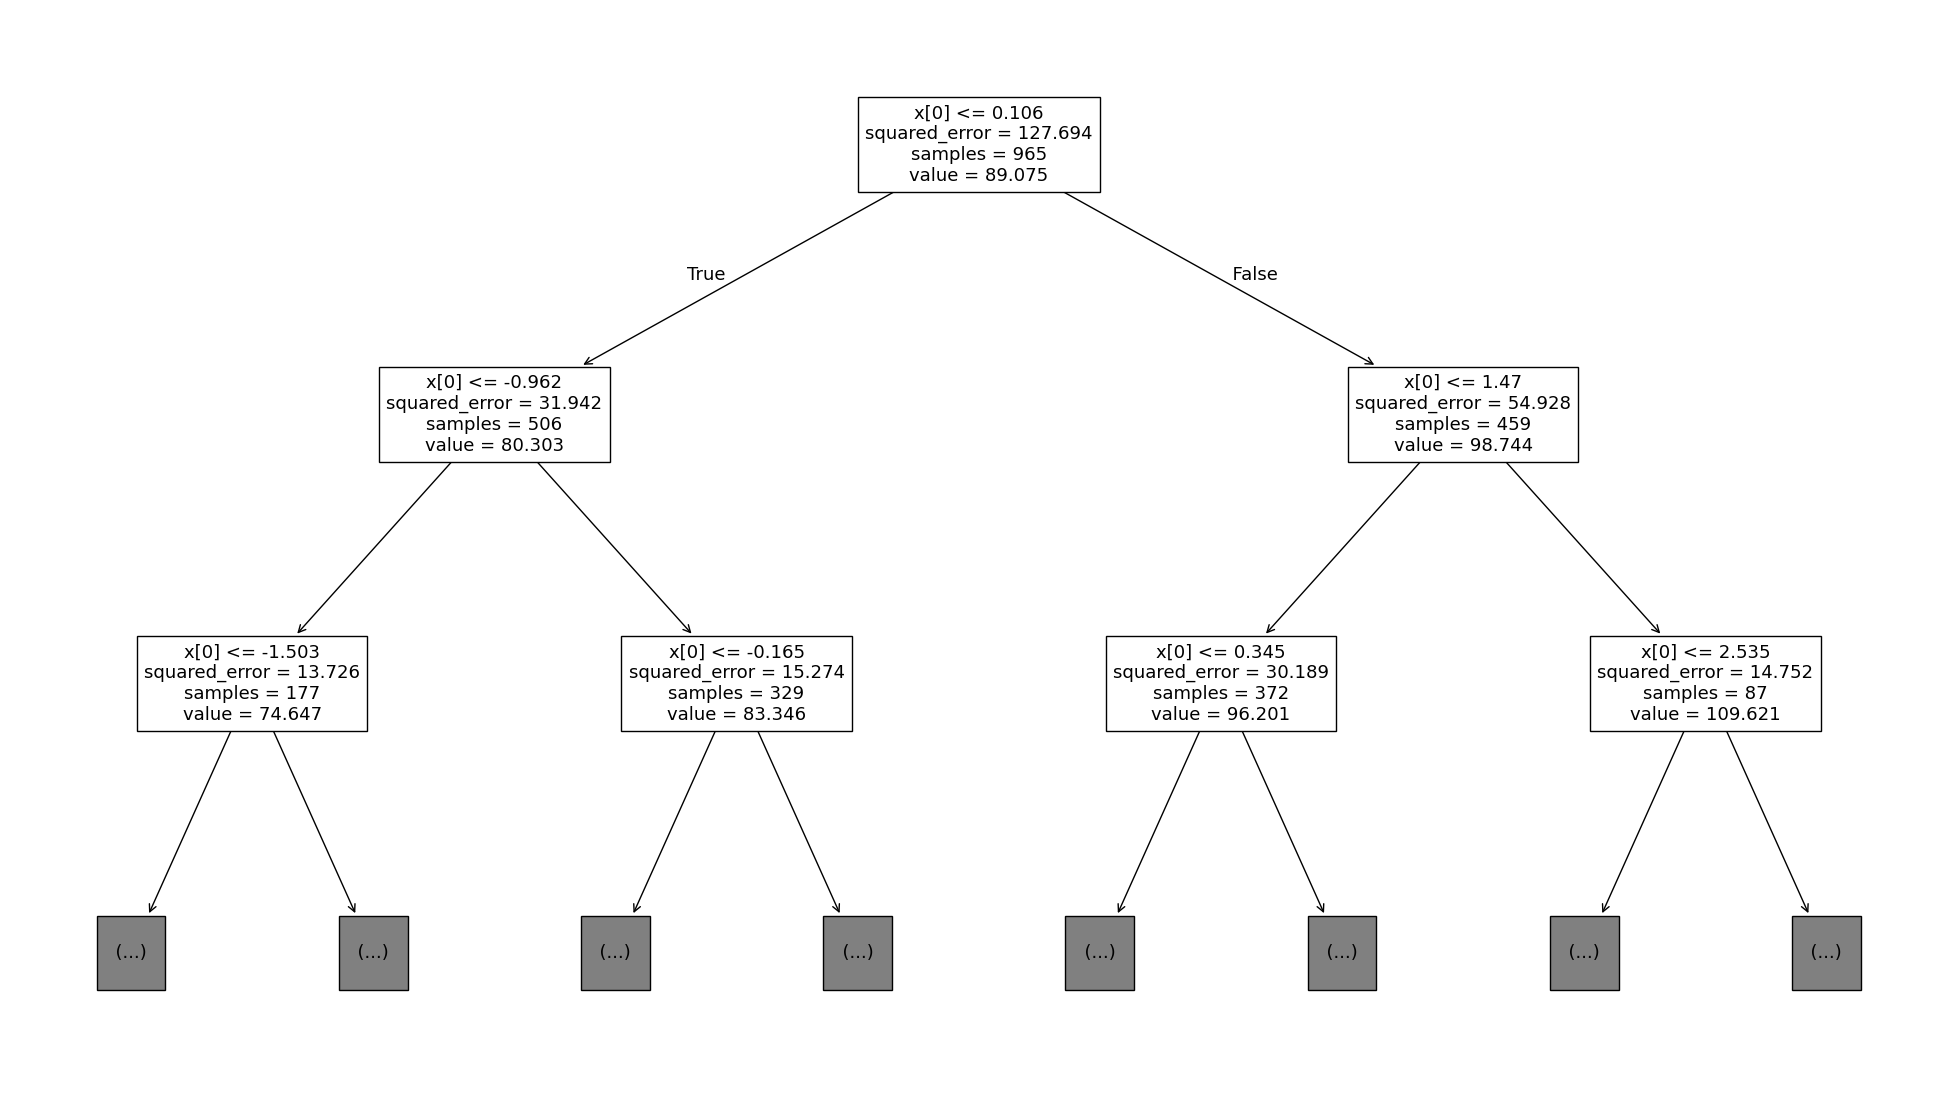

In [238]:
from sklearn.tree import plot_tree

plt.figure(figsize=(25, 14))
plot_tree(model['regr'], max_depth=2);

In [245]:
model = Pipeline([
    ('preproc', ColumnTransformer([
        ('numeric', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(include_bias=False))
        ]), numeric_vars),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_vars)
    ])),
    ('regr', Ridge())
])

grid = {
    'preproc__numeric__scaler': ['passthrough', StandardScaler()],
    "preproc__numeric__poly__degree": np.arange(1, 5),
    'regr__alpha': [0.01, 0.1, 1]
}

kf = KFold(3, shuffle=True, random_state=42)

gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train)
gs.score(X_test, y_test)

0.8569013320246696

In [246]:
gs.best_params_

{'preproc__numeric__poly__degree': 4,
 'preproc__numeric__scaler': 'passthrough',
 'regr__alpha': 0.01}